In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td

import devsim as ds

In [2]:
# generate BCs
def define_dirichlet(contact, T):
    name = "dirichlet_" + contact
    ds.contact_node_model(device="device", contact=contact, name=name, equation=f"T - {T}")
    ds.contact_node_model(device="device", contact=contact, name=name + ":T",equation="1")
    ds.contact_equation(device="device", contact=contact, name="HeatEquation", node_model=name)

def define_neumann(contact, q):
    name = "neuman_" + contact
    ds.contact_node_model(device="device", contact=contact, name=name,equation=f"{q}/NodeVolume*ContactSurfaceArea")
    ds.contact_equation(device="device", contact=contact, name="HeatEquation", node_model=name, element_model="heat_elem", )
    # ds.contact_equation(device="device", contact=contact, name="HeatEquation", node_model=name, edge_model="heat_flux", )

In [3]:
def source(region, Q):
    ds.node_model(device="device", region=region, name="source", equation=f"{Q}")

## Create mesh

In [4]:
def create_mesh(res = 0.05):
    ds.reset_devsim()
    ds.create_2d_mesh(mesh="mesh")

    dh = 0.1
    tol = 1e-6
    
    # bottom
    ds.add_2d_mesh_line(mesh="mesh", dir="y", pos=-1, ps=res)
    # create some more lines so that we can define contacts
    ds.add_2d_mesh_line(mesh="mesh", dir="y", pos=-1-dh, ps=res)
    
    # top
    ds.add_2d_mesh_line(mesh="mesh", dir="y", pos=1, ps=res)
    ds.add_2d_mesh_line(mesh="mesh", dir="y", pos=1+dh, ps=res)
    
    # right
    ds.add_2d_mesh_line(mesh="mesh", dir="x", pos=1, ps=res)
    ds.add_2d_mesh_line(mesh="mesh", dir="x", pos=1+dh, ps=res)
    
    # left
    ds.add_2d_mesh_line(mesh="mesh", dir="x", pos=-1, ps=res)
    ds.add_2d_mesh_line(mesh="mesh", dir="x", pos=-1-dh, ps=res)
    
    ds.add_2d_region(mesh="mesh", material="Si", region="core", xl=-1, xh=1, yl=-1, yh=1, bloat=tol)
    
    ds.add_2d_region(mesh="mesh", material="metal", region="buffer_bottom", xl=-1, xh=1, yl=-1-dh, yh=-1, bloat=tol)
    ds.add_2d_region(mesh="mesh", material="metal", region="buffer_top", xl=-1, xh=1, yl=1, yh=1+dh, bloat=tol)
    ds.add_2d_region(mesh="mesh", material="metal", region="buffer_right", xl=1, xh=1+dh, yl=-1, yh=1, bloat=tol)
    ds.add_2d_region(mesh="mesh", material="metal", region="buffer_left", xl=-1-dh, xh=-1, yl=-1, yh=1, bloat=tol)
    
    ds.add_2d_contact(mesh="mesh", name="contact_bottom", material="Si",region="core", xl=-1-dh, xh=1+dh, yl=-1, yh=-1-dh, bloat=tol)
    ds.add_2d_contact(mesh="mesh", name="contact_top", material="Si", region="core", xl=-1, xh=1, yl=1, yh=1)
    ds.add_2d_contact(mesh="mesh", name="contact_right", material="Si", region="core", xl=1, xh=1, yl=-1, yh=1)
    ds.add_2d_contact(mesh="mesh", name="contact_left", material="Si", region="core", xl=-1, xh=-1, yl=-1, yh=1)
    
    
    ds.finalize_mesh(mesh="mesh")
    ds.create_device(mesh="mesh", device="device")
create_mesh()

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.05, 0) (-1.05, -1.1, 0) (-1.08333, -1.08333, 0)
Triangle has no region: (-1.1, -1.05, 0) (-1.05, -1.1, 0) (-1.05, -1.05, 0) (-1.06667, -1.06667, 0)
Triangle has no region: (-1.1, -1.05, 0) (-1.1, -1, 0) (-1.05, -1.05, 0) (-1.08333, -1.03333, 0)
Triangle has no region: (-1.1, -1, 0) (-1.05, -1.05, 0) (-1.05, -1, 0) (-1.06667, -1.01667, 0)
Creating Region buffer_left
Triangle has no region: (-1.1, 1, 0) (-1.1, 1.05, 0) (-1.05, 1, 0) (-1.08333, 1.01667, 0)
Triangle has no region: (-1.1, 1.05, 0) (-1.05, 1, 0) (-1.05, 1.05, 0) (-1.06667, 1.03333, 0)
Triangle has no region: (-1.1, 1.05, 0) (-1.1, 1.1, 0) (-1.05, 1.05, 0) (-1.08333, 1.06667, 0)
Triangle has no region: (-1.1, 1.1, 0) (-1.05, 1.05, 0) (-1.05, 1.1, 0) (-1.06667, 1.08333, 0)
Triangle has no region: (-1.05, -1.1, 0) (-1.05, -1.05, 0) (-1, -1.1, 0) (-1.03333, -1.08333, 0)
Triangle has no region: (-1.05, -1.05, 0) (-1, -1.1, 0) (-1, -1.05, 0) (-1.01667, -1.06667, 0)

In [5]:
# set k
ds.set_parameter(device="device", region="core", name="k", value=1)

In [6]:
for region in ["core"]:
    ds.node_model(device="device", region=region, name="Tinit", equation="1")
    ds.node_solution(device="device", region=region, name="T")
    ds.set_node_values(device="device", region=region, name="T", init_from="Tinit")
    ds.edge_from_node_model(device="device", region=region, node_model="T")

    eq_heat = "-k*(T@n1 - T@n0)*EdgeInverseLength"
    ds.edge_model(device="device", region=region, name="heat_flux", equation=eq_heat)
    for n in ["n0", "n1"]:
        name = "heat_flux:T@" + n
        ds.edge_model(device="device", region=region, name=name, equation=f"diff({eq_heat}, T@{n})")

    source(region, 0)
    
    ds.equation(device="device", region=region, name="HeatEquation", variable_name="T", 
           edge_model="heat_flux", variable_update="positive", node_model="source")
    
ds.write_devices(file="heat", type="vtk")

In [7]:
T1 = 2
T0 = 1

# contact bottom
ds.contact_node_model(device="device", contact="contact_bottom", name="node_contact_bottom",equation=f"T-{T1}")
ds.contact_node_model(device="device", contact="contact_bottom", name="node_contact_bottom:T",equation="1")
ds.contact_equation(device="device", contact="contact_bottom", name="HeatEquation", node_model="node_contact_bottom")

# other contacts
for contact in ["contact_left", "contact_right", "contact_top"]:
    contact_name = "node_" + contact
    ds.contact_node_model(device="device", contact=contact, name=contact_name, equation=f"T-{T0}")
    ds.contact_node_model(device="device", contact=contact, name=contact_name+":T", equation="1")
    ds.contact_equation(device="device", contact=contact, name="HeatEquation", node_model=contact_name)

# contact derivatives
for contact in ["contact_left", "contact_right", "contact_top"]:
    contact_name = "node_" + contact
    for n in ["n0", "n1"]:
        ds.contact_node_model(device="device", contact=contact, name=f"{contact_name}:{n}",equation="1")

In [8]:
ds.solve(type="dc", absolute_error=1e-2, relative_error=1e-8, maximum_iterations=200)
ds.write_devices(file="heat", type="vtk")

number of equations 1681
Iteration: 0
  Device: "device"	RelError: 5.00000e-01	AbsError: 1.00000e+00
    Region: "core"	RelError: 5.00000e-01	AbsError: 1.00000e+00
      Equation: "HeatEquation"	RelError: 5.00000e-01	AbsError: 1.00000e+00
Iteration: 1
  Device: "device"	RelError: 8.02407e-16	AbsError: 1.44137e-15
    Region: "core"	RelError: 8.02407e-16	AbsError: 1.44137e-15
      Equation: "HeatEquation"	RelError: 8.02407e-16	AbsError: 1.44137e-15


## Now let's try to do the same with elements

In [9]:
create_mesh()

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.05, 0) (-1.05, -1.1, 0) (-1.08333, -1.08333, 0)
Triangle has no region: (-1.1, -1.05, 0) (-1.05, -1.1, 0) (-1.05, -1.05, 0) (-1.06667, -1.06667, 0)
Triangle has no region: (-1.1, -1.05, 0) (-1.1, -1, 0) (-1.05, -1.05, 0) (-1.08333, -1.03333, 0)
Triangle has no region: (-1.1, -1, 0) (-1.05, -1.05, 0) (-1.05, -1, 0) (-1.06667, -1.01667, 0)
Creating Region buffer_left
Triangle has no region: (-1.1, 1, 0) (-1.1, 1.05, 0) (-1.05, 1, 0) (-1.08333, 1.01667, 0)
Triangle has no region: (-1.1, 1.05, 0) (-1.05, 1, 0) (-1.05, 1.05, 0) (-1.06667, 1.03333, 0)
Triangle has no region: (-1.1, 1.05, 0) (-1.1, 1.1, 0) (-1.05, 1.05, 0) (-1.08333, 1.06667, 0)
Triangle has no region: (-1.1, 1.1, 0) (-1.05, 1.05, 0) (-1.05, 1.1, 0) (-1.06667, 1.08333, 0)
Triangle has no region: (-1.05, -1.1, 0) (-1.05, -1.05, 0) (-1, -1.1, 0) (-1.03333, -1.08333, 0)
Triangle has no region: (-1.05, -1.05, 0) (-1, -1.1, 0) (-1, -1.05, 0) (-1.01667, -1.06667, 0)

In [10]:
# set k
ds.set_parameter(device="device", region="core", name="k", value=1)

In [11]:
region = "core"
ds.node_model(device="device", region=region, name="Tinit", equation="1")
ds.node_solution(device="device", region=region, name="T")
ds.set_node_values(device="device", region=region, name="T", init_from="Tinit")
ds.edge_from_node_model(device="device", region=region, node_model="T")

eq_heat = "-k*(T@n1 - T@n0)*EdgeInverseLength"
ds.edge_model(device="device", region=region, name="heat_flux", equation=eq_heat)
for n in ["n0", "n1"]:
    name = "heat_flux:T@" + n
    ds.edge_model(device="device", region=region, name=name, equation=f"diff({eq_heat}, T@{n})")

# EEM for T
ds.element_from_node_model(device="device", region=region, node_model="T")

# now let's create an EEM for heat-flux
ds.element_from_edge_model(device="device", region=region, edge_model="heat_flux")
ds.element_from_edge_model(device="device", region=region, edge_model="heat_flux", derivative="T")

# unit EEM
ds.edge_model(device="device", region=region, name="edge_unit_x", equation="unitx")
ds.element_from_edge_model(device="device", region=region, edge_model="edge_unit_x")
ds.edge_model(device="device", region=region, name="edge_unit_y", equation="unity")
ds.element_from_edge_model(device="device", region=region, edge_model="edge_unit_y")

# now the model for our equation
eq = "heat_flux_x*edge_unit_x + heat_flux_y*edge_unit_y"
ds.element_model(device="device", region=region, name="heat_elem", equation=eq)
for n in ["en0", "en1", "en2"]:
    deq = f"heat_flux_x:T@{n}*edge_unit_x + heat_flux_y:T@{n}*edge_unit_y"
    ds.element_model(device="device", region=region, name=f"heat_elem:T@{n}", equation=deq)

source("core", -10)

# write equation using elements
ds.equation(device="device", region=region, name="HeatEquation", variable_name="T", 
       element_model="heat_elem", variable_update="default", 
        node_model="source"
)
    
ds.write_devices(file="heat_EEM", type="vtk")

In [12]:
define_neumann("contact_bottom", 0)
define_neumann("contact_top", 0)

define_dirichlet("contact_left", 10)
define_neumann("contact_right", 10)

In [13]:
ds.solve(type="dc", relative_error=0.06, absolute_error=2, maximum_iterations=200)
ds.write_devices(file="heat_EEM", type="vtk")

number of equations 1681
Iteration: 0
  Device: "device"	RelError: 9.32947e-01	AbsError: 1.39136e+01
    Region: "core"	RelError: 9.32947e-01	AbsError: 1.39136e+01
      Equation: "HeatEquation"	RelError: 9.32947e-01	AbsError: 1.39136e+01
Iteration: 1
  Device: "device"	RelError: 1.36730e-14	AbsError: 1.92743e-13
    Region: "core"	RelError: 1.36730e-14	AbsError: 1.92743e-13
      Equation: "HeatEquation"	RelError: 1.36730e-14	AbsError: 1.92743e-13


## MMS

In [14]:
def export_data():
    region = "core"
    # read T
    values = np.array(ds.get_node_model_values(device="device", region=region, name="T"))
    
    # read mesh connectivity
    cells = np.array(ds.get_element_node_list(device="device", region=region))
    
    # read mesh nodes coordinates
    part_xs = np.array(ds.get_node_model_values(device="device", region=region, name="x"))
    part_ys = np.array(ds.get_node_model_values(device="device", region=region, name="y"))
    points = np.transpose([part_xs, part_ys])
    
    # convert loaded data into TriangularGridDataset
    points_xr = td.PointDataArray(points, dims=["index", "axis"])
    cells_xr = td.CellDataArray(cells, dims=["cell_index", "vertex_index"])
    
    T_xr = td.IndexedDataArray(values, dims=["index"])
    T_data = td.TriangularGridDataset(points=points_xr, cells=cells_xr, values=T_xr, normal_pos=0, normal_axis=2)
    return T_data

In [15]:
def simulation_MMS(res = 0.05) -> float:
    create_mesh(res=res)
    # set k
    ds.set_parameter(device="device", region="core", name="k", value=1)

    region = "core"
    ds.node_model(device="device", region=region, name="Tinit", equation="1")
    ds.node_solution(device="device", region=region, name="T")
    ds.set_node_values(device="device", region=region, name="T", init_from="Tinit")
    ds.edge_from_node_model(device="device", region=region, node_model="T")
    
    eq_heat = "-k*(T@n1 - T@n0)*EdgeInverseLength"
    ds.edge_model(device="device", region=region, name="heat_flux", equation=eq_heat)
    for n in ["n0", "n1"]:
        name = "heat_flux:T@" + n
        ds.edge_model(device="device", region=region, name=name, equation=f"diff({eq_heat}, T@{n})")
    
    # EEM for T
    ds.element_from_node_model(device="device", region=region, node_model="T")
    
    # now let's create an EEM for heat-flux
    ds.element_from_edge_model(device="device", region=region, edge_model="heat_flux")
    ds.element_from_edge_model(device="device", region=region, edge_model="heat_flux", derivative="T")
    
    # unit EEM
    ds.element_from_edge_model(device="device", region=region, edge_model="unitx")
    ds.element_from_edge_model(device="device", region=region, edge_model="unity")
    
    # now the model for our equation
    eq = "heat_flux_x*unitx + heat_flux_y*unity"
    ds.element_model(device="device", region=region, name="heat_elem", equation=eq)
    for n in ["en0", "en1", "en2"]:
        deq = f"heat_flux_x:T@{n}*unitx + heat_flux_y:T@{n}*unity"
        ds.element_model(device="device", region=region, name=f"heat_elem:T@{n}", equation=deq)

    # source for T = (exp(x²-1)-1)*(exp(y²-1)-1)
    # source_eq = "2*(exp(y*y-1)-1)*exp(x*x-1)*(1+2*x*x) + 2*(exp(x*x-1)-1)*exp(y*y-1)*(1+2*y*y)" 
    # source for T = (x²-1)²(y²-1)²
    source_eq = "4.*(y*y-1.)*(y*y-1.)*(3.*x*x-1.) + 4.*(x*x-1.)*(x*x-1.)*(3.*y*y-1.)"
    # source_eq = "4.*(y*y-1.)*(y*y-1.)*(3.*x*x-1.)"
    ds.node_model(device="device", region=region, name="source", equation=source_eq)
    
    # write equation using elements
    ds.equation(device="device", region=region, name="HeatEquation", variable_name="T", 
           element_model="heat_elem", variable_update="default", 
            node_model="source"
    )

    # BCs
    for contact in ["contact_right", "contact_left", "contact_top", "contact_bottom"]:
        define_dirichlet(contact, 0)
    ds.solve(type="dc", relative_error=0.06, absolute_error=2, maximum_iterations=200)
    ds.write_devices(file="heat_MMS", type="vtk")

    sol_data = export_data()
    # sol_data.plot()
    # plt.show()

    # exact solution 
    X = np.linspace(-1, 1, 1000)
    Y = np.linspace(-1, 1, 1000)
    Xmesh, Ymesh = np.meshgrid(X, Y, indexing='ij')
    values = (np.exp(Xmesh*Xmesh-1) - 1)*(np.exp(Ymesh*Ymesh-1) - 1)
    values = (Xmesh*Xmesh-1)*(Xmesh*Xmesh-1)*(Ymesh*Ymesh-1)*(Ymesh*Ymesh-1)
    exact_solution = td.SpatialDataArray(data=values, coords=dict(x=X, y=Y))

    # interpo solution
    interp_sol = sol_data.interp(x=X, y=Y, z=0, fill_value="extrapolate")
    diff = np.abs(interp_sol - exact_solution)
    diff.plot()
    plt.show()
    error = np.sum(diff.data)/1e6
    return error

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1, 0) (-1, -1.1, 0) (-1.06667, -1.06667, 0)
Triangle has no region: (-1.1, -1, 0) (-1, -1.1, 0) (-1, -1, 0) (-1.03333, -1.03333, 0)
Creating Region buffer_left
Triangle has no region: (-1.1, 1, 0) (-1.1, 1.1, 0) (-1, 1, 0) (-1.06667, 1.03333, 0)
Triangle has no region: (-1.1, 1.1, 0) (-1, 1, 0) (-1, 1.1, 0) (-1.03333, 1.06667, 0)
Creating Region buffer_bottom
Creating Region core
Creating Region buffer_top
Triangle has no region: (1, -1.1, 0) (1, -1, 0) (1.1, -1.1, 0) (1.03333, -1.06667, 0)
Triangle has no region: (1, -1, 0) (1.1, -1.1, 0) (1.1, -1, 0) (1.06667, -1.03333, 0)
Creating Region buffer_right
Triangle has no region: (1, 1, 0) (1, 1.1, 0) (1.1, 1, 0) (1.03333, 1.03333, 0)
Triangle has no region: (1, 1.1, 0) (1.1, 1, 0) (1.1, 1.1, 0) (1.06667, 1.06667, 0)
Contact: contact_bottom region core ni: 0 ci: 14 (-1, -1, 0)
Contact: contact_left region core ni: 1 ci: 15 (-1, -0.8, 0)
Contact: contact_left region core ni: 

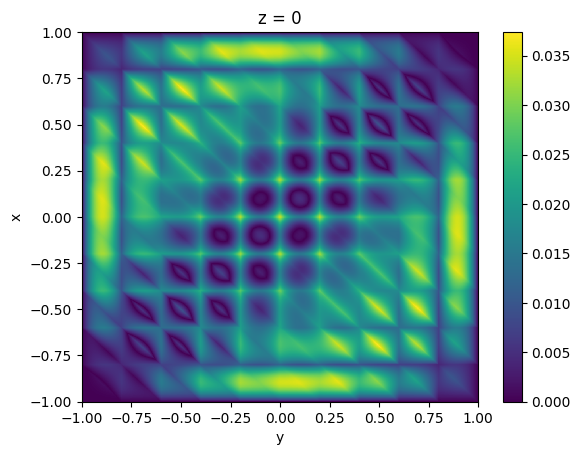

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.03571, 0) (-1.03571, -1.1, 0) (-1.07857, -1.07857, 0)
Triangle has no region: (-1.1, -1.03571, 0) (-1.03571, -1.1, 0) (-1.03571, -1.03571, 0) (-1.05714, -1.05714, 0)
Triangle has no region: (-1.1, -1.03571, 0) (-1.1, -1, 0) (-1.03571, -1.03571, 0) (-1.07857, -1.02381, 0)
Triangle has no region: (-1.1, -1, 0) (-1.03571, -1.03571, 0) (-1.03571, -1, 0) (-1.05714, -1.0119, 0)
Creating Region buffer_left
Triangle has no region: (-1.1, 1, 0) (-1.1, 1.06429, 0) (-1.03571, 1, 0) (-1.07857, 1.02143, 0)
Triangle has no region: (-1.1, 1.06429, 0) (-1.03571, 1, 0) (-1.03571, 1.06429, 0) (-1.05714, 1.04286, 0)
Triangle has no region: (-1.1, 1.06429, 0) (-1.1, 1.1, 0) (-1.03571, 1.06429, 0) (-1.07857, 1.07619, 0)
Triangle has no region: (-1.1, 1.1, 0) (-1.03571, 1.06429, 0) (-1.03571, 1.1, 0) (-1.05714, 1.0881, 0)
Triangle has no region: (-1.03571, -1.1, 0) (-1.03571, -1.03571, 0) (-1, -1.1, 0) (-1.02381, -1.07857, 0)
Triangle has no

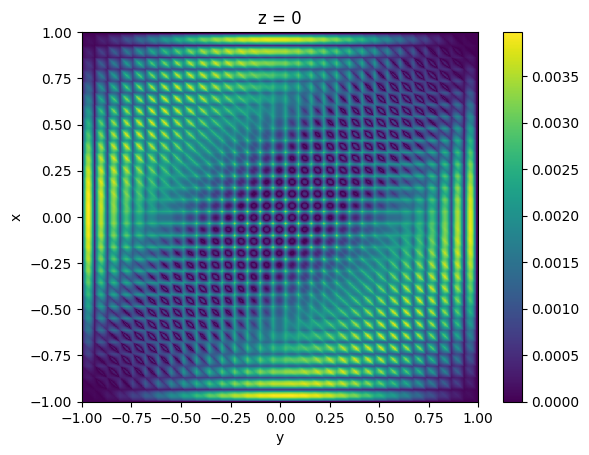

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.0617, 0) (-1.0617, -1.1, 0) (-1.08723, -1.08723, 0)
Triangle has no region: (-1.1, -1.0617, 0) (-1.0617, -1.1, 0) (-1.0617, -1.0617, 0) (-1.07447, -1.07447, 0)
Triangle has no region: (-1.1, -1.0617, 0) (-1.1, -1.0234, 0) (-1.0617, -1.0617, 0) (-1.08723, -1.04894, 0)
Triangle has no region: (-1.1, -1.0234, 0) (-1.0617, -1.0617, 0) (-1.0617, -1.0234, 0) (-1.07447, -1.03617, 0)
Triangle has no region: (-1.1, -1.0234, 0) (-1.1, -1, 0) (-1.0617, -1.0234, 0) (-1.08723, -1.0156, 0)
Triangle has no region: (-1.1, -1, 0) (-1.0617, -1.0234, 0) (-1.0617, -1, 0) (-1.07447, -1.0078, 0)
Creating Region buffer_left
Triangle has no region: (-1.1, 1, 0) (-1.1, 1.0383, 0) (-1.0617, 1, 0) (-1.08723, 1.01277, 0)
Triangle has no region: (-1.1, 1.0383, 0) (-1.0617, 1, 0) (-1.0617, 1.0383, 0) (-1.07447, 1.02553, 0)
Triangle has no region: (-1.1, 1.0383, 0) (-1.1, 1.0766, 0) (-1.0617, 1.0383, 0) (-1.08723, 1.05106, 0)
Triangle has no region: 

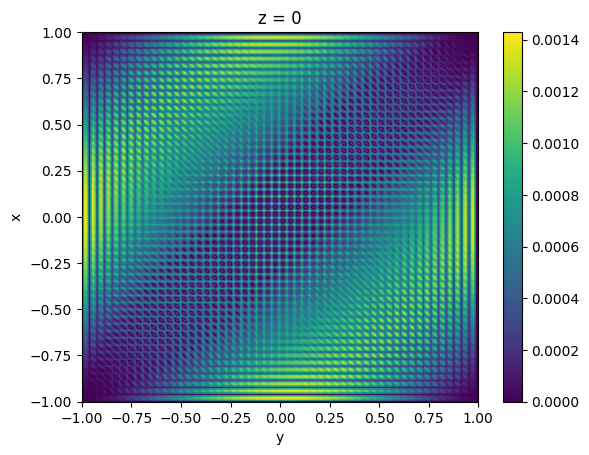

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.07273, 0) (-1.07273, -1.1, 0) (-1.09091, -1.09091, 0)
Triangle has no region: (-1.1, -1.07273, 0) (-1.07273, -1.1, 0) (-1.07273, -1.07273, 0) (-1.08182, -1.08182, 0)
Triangle has no region: (-1.1, -1.07273, 0) (-1.1, -1.04545, 0) (-1.07273, -1.07273, 0) (-1.09091, -1.06364, 0)
Triangle has no region: (-1.1, -1.04545, 0) (-1.07273, -1.07273, 0) (-1.07273, -1.04545, 0) (-1.08182, -1.05455, 0)
Triangle has no region: (-1.1, -1.04545, 0) (-1.1, -1.01818, 0) (-1.07273, -1.04545, 0) (-1.09091, -1.03636, 0)
Triangle has no region: (-1.1, -1.01818, 0) (-1.07273, -1.04545, 0) (-1.07273, -1.01818, 0) (-1.08182, -1.02727, 0)
Triangle has no region: (-1.1, -1.01818, 0) (-1.1, -1, 0) (-1.07273, -1.01818, 0) (-1.09091, -1.01212, 0)
Triangle has no region: (-1.1, -1, 0) (-1.07273, -1.01818, 0) (-1.07273, -1, 0) (-1.08182, -1.00606, 0)
Creating Region buffer_left
Triangle has no region: (-1.1, 1, 0) (-1.1, 1.02727, 0) (-1.07273, 1, 0) 

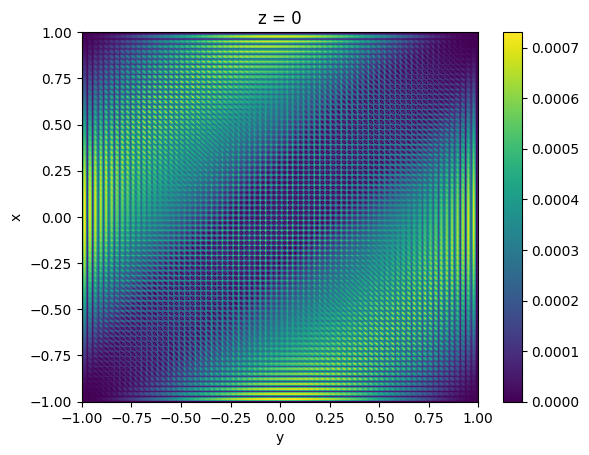

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.07882, 0) (-1.07882, -1.1, 0) (-1.09294, -1.09294, 0)
Triangle has no region: (-1.1, -1.07882, 0) (-1.07882, -1.1, 0) (-1.07882, -1.07882, 0) (-1.08588, -1.08588, 0)
Triangle has no region: (-1.1, -1.07882, 0) (-1.1, -1.05765, 0) (-1.07882, -1.07882, 0) (-1.09294, -1.07176, 0)
Triangle has no region: (-1.1, -1.05765, 0) (-1.07882, -1.07882, 0) (-1.07882, -1.05765, 0) (-1.08588, -1.06471, 0)
Triangle has no region: (-1.1, -1.05765, 0) (-1.1, -1.03647, 0) (-1.07882, -1.05765, 0) (-1.09294, -1.05059, 0)
Triangle has no region: (-1.1, -1.03647, 0) (-1.07882, -1.05765, 0) (-1.07882, -1.03647, 0) (-1.08588, -1.04353, 0)
Triangle has no region: (-1.1, -1.03647, 0) (-1.1, -1.01529, 0) (-1.07882, -1.03647, 0) (-1.09294, -1.02941, 0)
Triangle has no region: (-1.1, -1.01529, 0) (-1.07882, -1.03647, 0) (-1.07882, -1.01529, 0) (-1.08588, -1.02235, 0)
Triangle has no region: (-1.1, -1.01529, 0) (-1.1, -1, 0) (-1.07882, -1.01529, 0) (

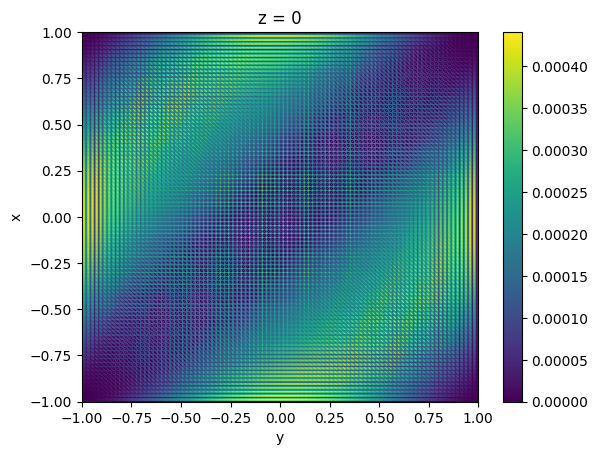

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.08269, 0) (-1.08269, -1.1, 0) (-1.09423, -1.09423, 0)
Triangle has no region: (-1.1, -1.08269, 0) (-1.08269, -1.1, 0) (-1.08269, -1.08269, 0) (-1.08846, -1.08846, 0)
Triangle has no region: (-1.1, -1.08269, 0) (-1.1, -1.06538, 0) (-1.08269, -1.08269, 0) (-1.09423, -1.07692, 0)
Triangle has no region: (-1.1, -1.06538, 0) (-1.08269, -1.08269, 0) (-1.08269, -1.06538, 0) (-1.08846, -1.07115, 0)
Triangle has no region: (-1.1, -1.06538, 0) (-1.1, -1.04808, 0) (-1.08269, -1.06538, 0) (-1.09423, -1.05962, 0)
Triangle has no region: (-1.1, -1.04808, 0) (-1.08269, -1.06538, 0) (-1.08269, -1.04808, 0) (-1.08846, -1.05385, 0)
Triangle has no region: (-1.1, -1.04808, 0) (-1.1, -1.03077, 0) (-1.08269, -1.04808, 0) (-1.09423, -1.04231, 0)
Triangle has no region: (-1.1, -1.03077, 0) (-1.08269, -1.04808, 0) (-1.08269, -1.03077, 0) (-1.08846, -1.03654, 0)
Triangle has no region: (-1.1, -1.03077, 0) (-1.1, -1.01346, 0) (-1.08269, -1.03077

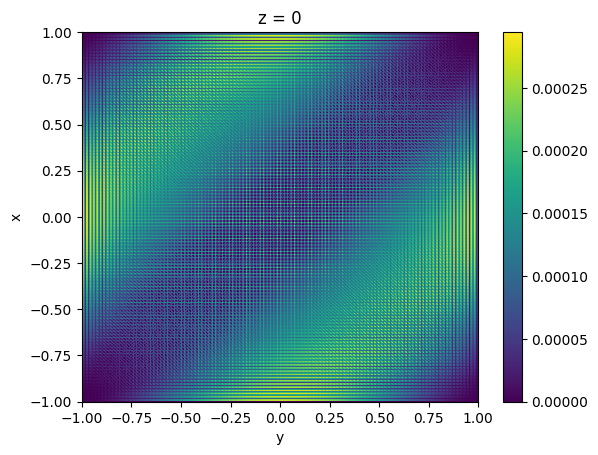

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.08537, 0) (-1.08537, -1.1, 0) (-1.09512, -1.09512, 0)
Triangle has no region: (-1.1, -1.08537, 0) (-1.08537, -1.1, 0) (-1.08537, -1.08537, 0) (-1.09024, -1.09024, 0)
Triangle has no region: (-1.1, -1.08537, 0) (-1.1, -1.07073, 0) (-1.08537, -1.08537, 0) (-1.09512, -1.08049, 0)
Triangle has no region: (-1.1, -1.07073, 0) (-1.08537, -1.08537, 0) (-1.08537, -1.07073, 0) (-1.09024, -1.07561, 0)
Triangle has no region: (-1.1, -1.07073, 0) (-1.1, -1.0561, 0) (-1.08537, -1.07073, 0) (-1.09512, -1.06585, 0)
Triangle has no region: (-1.1, -1.0561, 0) (-1.08537, -1.07073, 0) (-1.08537, -1.0561, 0) (-1.09024, -1.06098, 0)
Triangle has no region: (-1.1, -1.0561, 0) (-1.1, -1.04146, 0) (-1.08537, -1.0561, 0) (-1.09512, -1.05122, 0)
Triangle has no region: (-1.1, -1.04146, 0) (-1.08537, -1.0561, 0) (-1.08537, -1.04146, 0) (-1.09024, -1.04634, 0)
Triangle has no region: (-1.1, -1.04146, 0) (-1.1, -1.02683, 0) (-1.08537, -1.04146, 0) (

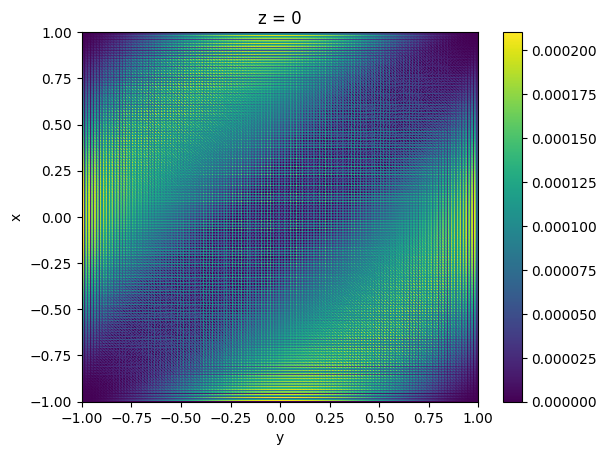

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.08732, 0) (-1.08732, -1.1, 0) (-1.09577, -1.09577, 0)
Triangle has no region: (-1.1, -1.08732, 0) (-1.08732, -1.1, 0) (-1.08732, -1.08732, 0) (-1.09155, -1.09155, 0)
Triangle has no region: (-1.1, -1.08732, 0) (-1.1, -1.07465, 0) (-1.08732, -1.08732, 0) (-1.09577, -1.0831, 0)
Triangle has no region: (-1.1, -1.07465, 0) (-1.08732, -1.08732, 0) (-1.08732, -1.07465, 0) (-1.09155, -1.07887, 0)
Triangle has no region: (-1.1, -1.07465, 0) (-1.1, -1.06197, 0) (-1.08732, -1.07465, 0) (-1.09577, -1.07042, 0)
Triangle has no region: (-1.1, -1.06197, 0) (-1.08732, -1.07465, 0) (-1.08732, -1.06197, 0) (-1.09155, -1.0662, 0)
Triangle has no region: (-1.1, -1.06197, 0) (-1.1, -1.0493, 0) (-1.08732, -1.06197, 0) (-1.09577, -1.05775, 0)
Triangle has no region: (-1.1, -1.0493, 0) (-1.08732, -1.06197, 0) (-1.08732, -1.0493, 0) (-1.09155, -1.05352, 0)
Triangle has no region: (-1.1, -1.0493, 0) (-1.1, -1.03662, 0) (-1.08732, -1.0493, 0) (-

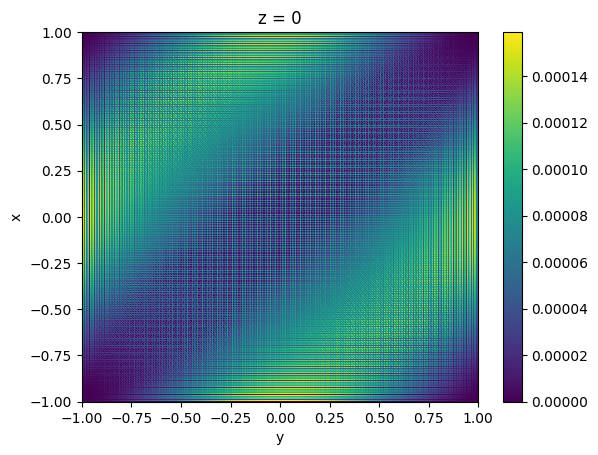

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.08882, 0) (-1.08882, -1.1, 0) (-1.09627, -1.09627, 0)
Triangle has no region: (-1.1, -1.08882, 0) (-1.08882, -1.1, 0) (-1.08882, -1.08882, 0) (-1.09255, -1.09255, 0)
Triangle has no region: (-1.1, -1.08882, 0) (-1.1, -1.07764, 0) (-1.08882, -1.08882, 0) (-1.09627, -1.08509, 0)
Triangle has no region: (-1.1, -1.07764, 0) (-1.08882, -1.08882, 0) (-1.08882, -1.07764, 0) (-1.09255, -1.08137, 0)
Triangle has no region: (-1.1, -1.07764, 0) (-1.1, -1.06646, 0) (-1.08882, -1.07764, 0) (-1.09627, -1.07391, 0)
Triangle has no region: (-1.1, -1.06646, 0) (-1.08882, -1.07764, 0) (-1.08882, -1.06646, 0) (-1.09255, -1.07019, 0)
Triangle has no region: (-1.1, -1.06646, 0) (-1.1, -1.05528, 0) (-1.08882, -1.06646, 0) (-1.09627, -1.06273, 0)
Triangle has no region: (-1.1, -1.05528, 0) (-1.08882, -1.06646, 0) (-1.08882, -1.05528, 0) (-1.09255, -1.05901, 0)
Triangle has no region: (-1.1, -1.05528, 0) (-1.1, -1.0441, 0) (-1.08882, -1.05528,

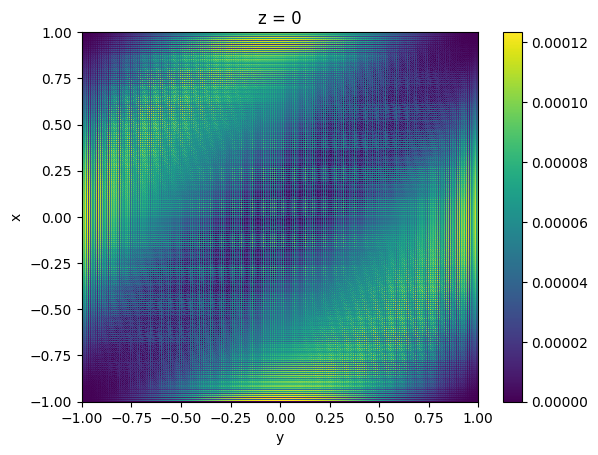

Resetting DEVSIM
Triangle has no region: (-1.1, -1.1, 0) (-1.1, -1.09, 0) (-1.09, -1.1, 0) (-1.09667, -1.09667, 0)
Triangle has no region: (-1.1, -1.09, 0) (-1.09, -1.1, 0) (-1.09, -1.09, 0) (-1.09333, -1.09333, 0)
Triangle has no region: (-1.1, -1.09, 0) (-1.1, -1.08, 0) (-1.09, -1.09, 0) (-1.09667, -1.08667, 0)
Triangle has no region: (-1.1, -1.08, 0) (-1.09, -1.09, 0) (-1.09, -1.08, 0) (-1.09333, -1.08333, 0)
Triangle has no region: (-1.1, -1.08, 0) (-1.1, -1.07, 0) (-1.09, -1.08, 0) (-1.09667, -1.07667, 0)
Triangle has no region: (-1.1, -1.07, 0) (-1.09, -1.08, 0) (-1.09, -1.07, 0) (-1.09333, -1.07333, 0)
Triangle has no region: (-1.1, -1.07, 0) (-1.1, -1.06, 0) (-1.09, -1.07, 0) (-1.09667, -1.06667, 0)
Triangle has no region: (-1.1, -1.06, 0) (-1.09, -1.07, 0) (-1.09, -1.06, 0) (-1.09333, -1.06333, 0)
Triangle has no region: (-1.1, -1.06, 0) (-1.1, -1.05, 0) (-1.09, -1.06, 0) (-1.09667, -1.05667, 0)
Triangle has no region: (-1.1, -1.05, 0) (-1.09, -1.06, 0) (-1.09, -1.05, 0) (-1.0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



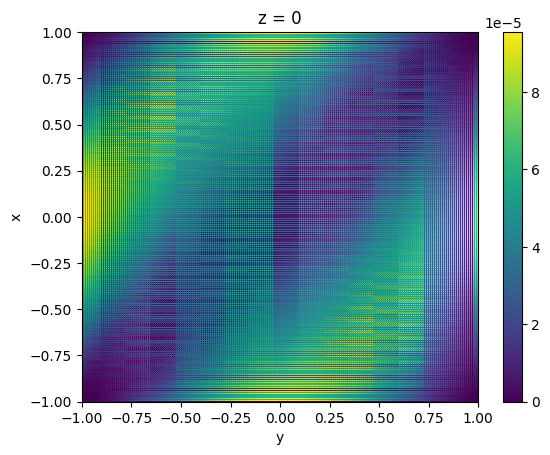

In [16]:
errors = []
dhs = []
for n in np.linspace(10, 200, 10):
    dh = 2 / n
    error = simulation_MMS(res=dh)
    dhs.append(dh)
    errors.append(error)

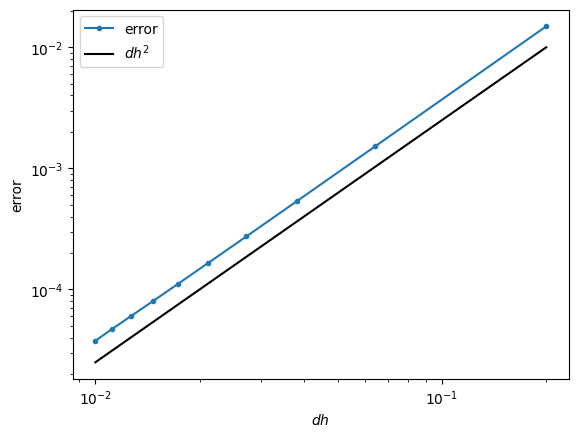

In [17]:
dhs = np.array(dhs)
err2 = dhs*dhs/4
plt.loglog(dhs, errors, '.-', label="error")
plt.loglog(dhs, err2, 'k-', label="$dh^2$")
plt.xlabel("$dh$")
plt.ylabel("error")
plt.legend()
plt.show()